# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calibrating and synthetic simulations of Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Spatio Temporal Neyman Scott Rectangular Pulse Model) using several rainfall series from Tenerife Island with a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import tqdm

In [3]:
import math as mt
from datetime import date
from datetime import timedelta
from scipy import stats

In [4]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics
from haversine import haversine, Unit
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min

#from NSRP.Simulation import Simulation
#from NSRP.utils import compare_statistics, exceedence_probability#, disaggregate_rainfall

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

### Loading daily rainfall for Tenerife Island (now for Sierra Nevada)

In [6]:
path_1 = './auxiliary-materials/SIERRA_NEVADA/'

In [7]:
## Loading rainfall series
Series_SN = pd.read_csv(path_1 + 'DailyGuadalfeo.csv', index_col=0, parse_dates=True)
Series_SN[Series_SN.values<0]=np.nan
Input_Series=Series_SN.copy()
del Series_SN

In [8]:
## Loading attributes for the series
Attributes_SN = pd.read_csv(path_1 + 'AtributosGuadalfeo.csv', index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=[str(i) for i in Attributes_SN.field_1.values]
Input_Attr['X']=Attributes_SN.Long.values
Input_Attr['Y']=Attributes_SN.Lat.values
Input_Attr['Elevation']=Attributes_SN.field_4.values

In [9]:
#from pyproj import Proj
#myProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [10]:
## Shorting ID series to match with Input_Attr
Input_Series = Input_Series[Input_Attr.ID]

In [11]:
## Quitar esto. Por ahora selecciono únicamente 5 estaciones para que no tarde tanto
Input_Series = Input_Series.iloc[: , 0:5]
Input_Attr = Input_Attr.head(5)

In [52]:
Input_Attr

[autoreload of NEOPRENE.STNSRP.libs_STNSRP failed: Traceback (most recent call last):
  File "C:\Users\navass\Anaconda3\envs\NEOPRENE\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\navass\Anaconda3\envs\NEOPRENE\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\navass\Anaconda3\envs\NEOPRENE\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\navass\Anaconda3\envs\NEOPRENE\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_fr

,ID,X,Y,Elevation
0,84,-3.727965,36.891830,1120
1,86,-3.191845,36.975170,1319
2,87,-3.183510,36.943227,916
3,88,-3.300181,36.876554,684
4,89,-3.268236,37.001560,1476


### Plotting rainfall series, seasonality and gauge position

Text(0, 0.5, 'mm/month')

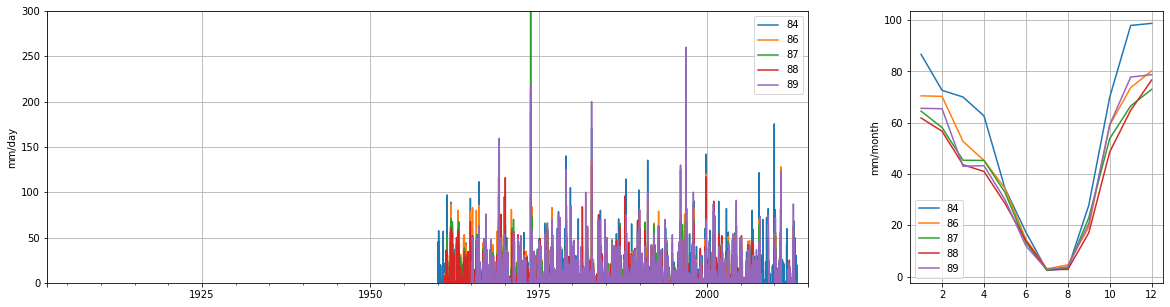

In [12]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

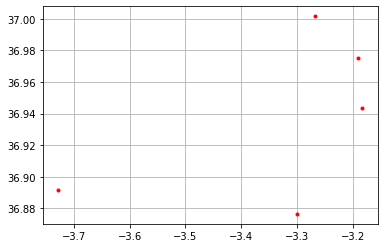

In [13]:
plt.plot(Input_Attr.X, Input_Attr.Y, '.r')
plt.grid()

### Calibration

Compleate...

In [14]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SN.yml')

In [15]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_Bilbao.csv')

e:\github\neoprene\NEOPRENE\STNSRP\libs_STNSRP.py:148: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Correlacion_distancia=pd.DataFrame(np.vstack({tuple(row) for row in Correlacion_distancia.values}), columns=['Corr', 'dist'])


In [16]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=True)
#CAL1.save_files('./CAL3/')#save python objects

[20, 1000]


################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)



Fitting the months = (1, 2, 3)

Initialization number  = 0


e:\github\neoprene\NEOPRENE\STNSRP\MathematicalPropertiesSTNSRP.py:114: RuntimeWarning: invalid value encountered in log
  (landa[i]/betha[i])*(0.577 + np.log(((eta[i]/(eta[i]-betha[i]))-exp(-betha[i]*h))*(mu_c[i]))))))


Initial best position  61.25448289961613 [2.96879638e-01 4.99892321e+01 5.69121577e+02 1.25953899e+00
 1.19376203e+00 4.02565260e-02]
Iteration number  = 0
Total error = 61.25448289961613
Iteration number  = 1
Total error = 61.25448289961613
Iteration number  = 2
Total error = 19.805295370829448
Iteration number  = 3
Total error = 8.348668869782484
Iteration number  = 4
Total error = 8.348668869782484
Iteration number  = 5
Total error = 8.348668869782484
Iteration number  = 6
Total error = 7.547396138110278
Iteration number  = 7
Total error = 7.096818591312792
Iteration number  = 8
Total error = 7.017866619757676
Iteration number  = 9
Total error = 6.884147398688371
Iteration number  = 10
Total error = 6.884147398688371
Iteration number  = 11
Total error = 6.797210803743695
Iteration number  = 12
Total error = 6.762224472626695
Iteration number  = 13
Total error = 6.748699631753921
Iteration number  = 14
Total error = 6.744500249018508
Iteration number  = 15
Total error = 6.74450024901

In [17]:
CAL1.Fitted_parameters

,"(1, 2, 3)","(4, 5, 6)","(7, 8, 9)","(10, 11, 12)"
landa,0.034633,0.029873,0.024000,0.024000
ipsilon,100.000000,100.000000,40.441481,100.000000
eta,16.588060,524.837180,1600.000000,16.173898
betha,0.947770,1.310272,1.491951,1.061299
fi_may,0.100000,0.824588,0.100000,0.100000
fi_may_s,0.025000,0.025000,0.025000,0.025000


In [18]:
import math as mt
from math import *

In [19]:
def scale_funtion(x, landa, ipsilon, eta, alpha):
    return (((landa*mt.gamma(2)*ipsilon))/(x*eta))

In [20]:
def index_string(param, string):
    if string in param:
        param_list=list(param)
        return param_list.index(string)
    else:
        return None

In [21]:
def XI_MONTHS(Input_Series, CAL1, CAL):
    """Calculate the scale parameter for every gauge and season"""
    process = CAL.hiperparams.process
    Dataframe_xi=pd.DataFrame(index=CAL1.Fitted_parameters.columns)
    for gauge in Input_Series.columns:
        xis=list()
        for season in CAL1.Fitted_parameters.columns:
            posi=np.where(np.in1d(Input_Series.index.month, season, assume_unique=True))[0]
            mean_rain=np.nanmean(Input_Series[gauge][posi])
            if process=='normal':
                if index_string(CAL1.Fitted_parameters, 'alpha')!=None: alpha=CAL1.Fitted_parameters[season]['alpha']
                else: alpha=1
                xis.append(scale_funtion(mean_rain,CAL1.Fitted_parameters[season]['landa'],\
                                         CAL1.Fitted_parameters[season]['ipsilon'], CAL1.Fitted_parameters[season]['eta'],alpha))
            elif process=='storms':
                if index_string(CAL1.Fitted_parameters.index, 'alpha1')!=None: 
                    alpha1=CAL1.Fitted_parameters[season]['alpha1']; alpha1=CAL1.Fitted_parameters[season]['alpha2']; 
                else: alpha1=1; alpha2=1
                xi1=(scale_funtion(mean_rain,CAL1.Fitted_parameters[season]['landa1'],\
                         CAL1.Fitted_parameters[season]['ipsilon1'], CAL1.Fitted_parameters[i]['eta1'],alpha1))
                xi2=(scale_funtion(mean_rain,Dataframe_parametros[season]['landa1'],\
                         CAL1.Fitted_parameters[season]['ipsilon1'], CAL1.Fitted_parameters[i]['eta2'],alpha2))
                xis.append(xi1+xi2)

        Dataframe_xi[gauge]=xis

    # Sorting dataframe 
    Dataframe_xi_meses=pd.DataFrame(columns=Dataframe_xi.columns)
    for i in Dataframe_xi.index:
        if np.size(i)==1: Dataframe_xi_meses.loc[i]=Dataframe_xi.loc[[i]].values[0]
        else: 
            for mm in np.arange(1,13): 
                if mm in i: Dataframe_xi_meses.loc[mm]=Dataframe_xi.loc[[i]].values[0]
    
    return Dataframe_xi_meses

In [22]:
def NSRP_simulation(Params_month, year_ini, year_fin, temporal_resolution,process, Seasonality):

    landa=Params_month[Params_month.index=='landa'].values[0];Storm_origin=1/landa
    ipsilon=Params_month[Params_month.index=='ipsilon'].values[0];Number_cells_per_storm=ipsilon-1
    
    if process=='normal':
        eta=Params_month[Params_month.index=='eta'].values[0]; Time_cell=1/eta
        xi=Params_month[Params_month.index=='xi'].values[0]; Intensity_cell=1/xi

    betha=Params_month[Params_month.index=='betha'].values[0]; Dist_cell_origin=1/betha


    time_d=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='D')
    time_h=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='h')
    time_min=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='min')

    Df_sim_join_day  =pd.DataFrame(index=time_d, columns = ['Rain'])
    Df_sim_join_hour =pd.DataFrame(index=time_h, columns = ['Rain'])


    Intensity_cells_total=list()
    Time_cells_total = list()

    for perio, monthss in enumerate(Seasonality):
        n_days=np.sum(np.in1d(Df_sim_join_day.index.month, monthss))
        position_day=np.in1d(Df_sim_join_day.index.month, monthss)
        position_hour=np.in1d(Df_sim_join_hour.index.month, monthss)

        Df_sim_day_aux  = pd.period_range('1800', periods=n_days, freq='D')
        Df_sim_hour_aux = pd.period_range('1800', periods=n_days*24, freq='h')
        Df_sim_min_aux  = pd.period_range('1800', periods=n_days*24*60, freq='min')

        time_star=datetime.datetime.strptime(str(Df_sim_day_aux[0]), '%Y-%m-%d')
        time_end=datetime.datetime.strptime(str(Df_sim_day_aux[-1]), '%Y-%m-%d')
        time_lapso=time_star
        
        time_storm_origins=list()
        n=0

        if np.size(monthss)==1:
            monthss=[monthss]
        else:
            monthss=[perio+1]


        while time_lapso < time_end:
            
            s = np.random.exponential(Storm_origin[monthss[0]-1], 1)
            if temporal_resolution=='d':
                time_lapso=time_lapso +  datetime.timedelta(days=s[0])
            elif temporal_resolution=='h':
                time_lapso=time_lapso +  datetime.timedelta(hours=s[0])

            time_storm_origins.append(time_lapso)
            n=n+1


        n_storms=len(time_storm_origins)
        
        Number_cell_per_storm=list()
        for i, ii in enumerate(time_storm_origins):
            Number_cell_per_storm.append(1 + (np.random.poisson(Number_cells_per_storm[monthss[0]-1], 1)))
        

        time0 = time_star
        time_ini_cells=list()
        time_fin_cells=list()
        Intensity_cells = list()
        Time_hours_cells = list()
        for i in range(n_storms):
            time1=time_storm_origins[i]
            Distance_hours_cell_sim=np.random.exponential(scale=Dist_cell_origin[monthss[0]-1], size=Number_cell_per_storm[i])

            if process=='normal':
                Time_hours_cell_sim=np.random.exponential(scale=Time_cell[monthss[0]-1], size=Number_cell_per_storm[i])
                
                Intensity_cell_sim=np.random.exponential(scale=Intensity_cell[monthss[0]-1], size=Number_cell_per_storm[i])


              

            for j in range(Number_cell_per_storm[i][0]):

                if temporal_resolution=='d':
                    time1_cell=time1 + datetime.timedelta(days=Distance_hours_cell_sim[j])
                    time2_cell=time1_cell + datetime.timedelta(days=Time_hours_cell_sim[j])

                elif temporal_resolution=='h':
                    time1_cell=time1 + datetime.timedelta(hours=Distance_hours_cell_sim[j])
                    time2_cell=time1_cell + datetime.timedelta(hours=Time_hours_cell_sim[j])

                Intensity=Intensity_cell_sim[j]
                time_ini_cells.append(time1_cell)
                time_fin_cells.append(time2_cell)
                Intensity_cells.append(Intensity)
                Time_hours_cells.append(Time_hours_cell_sim[j])

        ################################################################################
        time_ini_cells=np.array(time_ini_cells)
        time_fin_cells=np.array(time_fin_cells)
        Intensity_cells=np.array(Intensity_cells)
        Time_hours_cells=np.array(Time_hours_cells)
        #################################################################################
        ############################################################################
        tt=pd.period_range(start=Df_sim_day_aux[0],end=Df_sim_day_aux[-1], freq='min')
        tt_ordinal=tt.astype(np.int32)*60*10**9
        ############################################################################
        Anhos=list()
        for i, ii in enumerate(time_fin_cells):
            aux=ii; year_aux=aux.year
            Anhos.append(year_aux)
        In_datess=np.where(np.array(Anhos)<=Df_sim_day_aux.year[-1])
        time_ini_cellss=time_ini_cells[In_datess[0]]
        time_fin_cellss=time_fin_cells[In_datess[0]]
        Intensity_cellss=Intensity_cells[In_datess[0]]; Intensity_cells_total.append(Intensity_cellss)
        Time_hours_cellss=Time_hours_cells[In_datess[0]]; Time_cells_total.append(Time_hours_cellss)
        
        t_ini = np.hstack([time_ini_cellss, time_fin_cellss])
        if process=='cells':
            i_ini = np.hstack([Intensity_cellss.T, -Intensity_cellss.T])
            i_ini = i_ini[0]
        else: 
            i_ini = np.hstack([Intensity_cellss, -Intensity_cellss])
        orden = np.argsort(t_ini)
        t = t_ini[orden]
        i = np.cumsum(i_ini[orden])
        i[i<0] = 0
        rain=i.copy()
        t_ordinal = pd.PeriodIndex(t.astype(str),freq='N').astype(np.int32)
        if np.size(t_ordinal)==0:
            a=1
        else:
            rainfall = interp1d(t_ordinal, rain, kind="zero", bounds_error=False, fill_value=0.)
            rr = rainfall(tt_ordinal)
            Date=pd.DataFrame(index=tt)
            if temporal_resolution=='d':
                Date['Rain']=rr/(60*24)
            elif temporal_resolution=='h':
                Date['Rain']=rr/(60)
            df = Date.copy()
            del Date
            #df2 = pd.DataFrame(df.groupby([df.index.year,df.index.month,df.index.day])[['Rain']].sum().values,index = pd.period_range(start=df.index[0],end=df.index[-1],freq='D'))
            #df3 = pd.DataFrame(df.groupby([df.index.year,df.index.month,df.index.day,df.index.hour])[['Rain']].sum().values,index = pd.period_range(start=df.index[0],end=df.index[-1],freq='h'))
            #Df_sim_join_day['Rain'].iloc[np.where(position_day)[0][0:len(df2)]]=df2.values.flatten()
            #Df_sim_join_hour['Rain'].iloc[np.where(position_hour)[0][0:len(df3)]]=df3.values.flatten()
            df2 = np.ravel(df.resample('D').sum().values)
            df3 = np.ravel(df.resample('h').sum().values)
            Df_sim_join_day['Rain'].iloc[np.where(position_day)[0][0:len(df2)]] = df2
            Df_sim_join_hour['Rain'].iloc[np.where(position_hour)[0][0:len(df3)]] = df3
            
            
        del rr, rainfall, tt, t_ordinal,tt_ordinal, rain, i, t, orden, t_ini, i_ini,df, df3, df2
    return Df_sim_join_hour, Df_sim_join_day,\
           np.hstack(Intensity_cells_total), np.hstack(Time_cells_total)

In [23]:
Dataframe_xi_months = XI_MONTHS(Input_Series, CAL1, CAL)

### Checking if punctual model works

In [24]:
Params_month = CAL1.Fitted_parameters.copy()
year_ini = 2020
year_fin = 2070
temporal_resolution = 'd'
Seasonality = hiper_params_cal.Seasonality
process = 'normal'
xi_jo = pd.DataFrame(index = ['xi'], columns = Params_month.columns)
Params_month = pd.concat([Params_month, xi_jo])

for n_g, gauge in enumerate(Input_Series.columns):
    print(n_g)
    for sea in Seasonality:
        Params_month[sea].loc['xi'] = [Dataframe_xi_months[gauge].loc[n] for n in Dataframe_xi_months.index if n == sea[0]][0]
    df_hour, df_day, Ic, Tc = NSRP_simulation(Params_month, year_ini, year_fin, temporal_resolution, process, Seasonality)
    #df_hour, df_day, Ic, Tc = NSRP_simulation_Javi(Params_month, year_ini, year_fin, temporal_resolution, 'E', process, Seasonality)
    if n_g == 0:
        Dataframe_simulated_puntual = pd.DataFrame(index = df_day.index)
    Dataframe_simulated_puntual[gauge] = df_day['Rain']

0


C:\Users\navass\AppData\Local\Temp/ipykernel_17504/3989762726.py:106: FutureWarning: casting period[T] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tt_ordinal=tt.astype(np.int32)*60*10**9
C:\Users\navass\AppData\Local\Temp/ipykernel_17504/3989762726.py:129: FutureWarning: casting period[N] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_ordinal = pd.PeriodIndex(t.astype(str),freq='N').astype(np.int32)


1
2
3
4


### Simulation

The input simulation file ([Input_Sim_Bilbao.yml](https://github.com/navass11/STNSRPM/blob/Javi/notebooks/Input_Sim_Bilbao.yml)) contains the hypermarametes for rainfall simulation.

Here we breifly explain the hyperparamters available in the simulation file [Input_Sim_Bilbao.yml](https://github.com/navass11/STNSRPM/blob/Javi/notebooks/Input_Sim_Bilbao.yml) are described bellow:

- **Seasonality_type**:

- **Seasonality_user**:  

- **statistics_name**:

- **temporal_resolution**:

- **process**:

- **year_ini**:

- **year_fin**: 


In [34]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SN.yml')

In [36]:
Parametros_meses = allmonths(CAL1.Fitted_parameters)
#Dataframe_xi_months = allmonths(Dataframe_xi_months)
process = CAL.hiperparams.process
storm_radius = CAL.hiperparams.storm_radius
coordinates = CAL.hiperparams.coordinates
XX = Input_Attr.X
YY = Input_Attr.Y

In [37]:
from shapely.geometry import Point
from shapely.geometry import Polygon
#from descartes.patch import PolygonPatch
def mean_area_intersect_rectangle_circle(x_lim, y_lim, radius, plott):
    ##Calculo el aréa media que intersecta un rectangulo (fijo) y un circulo cuyo centro se va moviendo a lo largo
    ## del rectangulo (Sería integrar entre x e y. pero lo hago numericamente)
    ##x_lim y y_lim serían las esquinas del rectangulo
    
    min_x=np.min(x_lim)
    max_x=np.max(x_lim)
    min_y=np.min(y_lim)
    max_y=np.max(y_lim)
    
    rectangle= Polygon([(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y), (min_x, min_y)])##creo rectangulo

    xx=np.linspace(x_lim[0], x_lim[1], 100)
    yy=np.linspace(y_lim[0], y_lim[1], 100)
    [XX, YY]=np.meshgrid(xx, yy)
    XX_reshape=XX.reshape(np.size(XX), 1)
    YY_reshape=YY.reshape(np.size(YY), 1)
    
    area_medio=list()
    for i in range(len(XX_reshape)):
        circle=Point(XX_reshape[i],YY_reshape[i]).buffer(radius)##creo circulo
        diferencia=rectangle.intersection(circle)##calculo intersección
        
        if plott=='True':
        
            fig = pyplot.figure(1, figsize=(10, 5), dpi=90)
            # 1: valid polygon
            ax = fig.add_subplot(121)
            patch = PolygonPatch(rectangle, facecolor='b', edgecolor='b', alpha=0.5, zorder=2)
            ax.add_patch(patch)
            patch = PolygonPatch(circle, facecolor='r', edgecolor='r', alpha=0.5, zorder=2)
            ax.add_patch(patch)
            xrange = [-1, 5]
            yrange = [-1, 5]
            ax.set_xlim(*xrange)
            #ax.set_xticks(range(*xrange) + [xrange[-1]])
            ax.set_ylim(*yrange)
            #ax.set_yticks(range(*yrange) + [yrange[-1]])
            #ax.set_aspect(1)

            # 2: intersection
            ax = fig.add_subplot(122)
            patch = PolygonPatch(diferencia, facecolor='g', edgecolor='g', alpha=0.5, zorder=2)
            ax.add_patch(patch)
            xrange = [-1, 5]
            yrange = [-1, 5]
            ax.set_xlim(*xrange)
            #ax.set_xticks(range(*xrange) + [xrange[-1]])
            ax.set_ylim(*yrange)
            #ax.set_yticks(range(*yrange) + [yrange[-1]])
            #ax.set_aspect(1)
        
        area_medio.append(diferencia.area)
    return (np.mean(area_medio))

In [38]:
def distancia_f(x1, y1, x2, y2):
    dist=((x1-x2)**2 + (y1-y2)**2)**0.5
    return dist

In [39]:
landa=Parametros_meses[Parametros_meses.index=='landa'].values[0];Storm_origin=1/landa##Poisson process
ipsilon=Parametros_meses[Parametros_meses.index=='ipsilon'].values[0];Number_cells_per_storm=ipsilon-1##Random poisson mean ¿ipsilon-1?
if process=='normal':
    eta=Parametros_meses[Parametros_meses.index=='eta'].values[0]; Duracion_cell=1/eta##exponencial random
    #if I_F=='W' or I_F=='G':
    #    alpha=Parametros_meses[Parametros_meses.index=='alpha'].values[0];

betha=Parametros_meses[Parametros_meses.index=='betha'].values[0]; Dist_cell_origin=1/betha##exponencial random

fi_may=Parametros_meses[Parametros_meses.index=='fi_may'].values[0]; Radio=1/fi_may
if storm_radius==True:
    fi_may_s=Parametros_meses[Parametros_meses.index=='fi_may_s'].values[0]; Radio_s=1/fi_may_s
    
#Two dimensional poisson process (lo más simple sería incrustar mi grid en un cuadrado, simular para el cuadrado, 
#y luego sólo mantener los puntos en la región de destino.
#print('Maximo radio = ' + str(np.max(np.random.exponential(scale=1/fi_may, size=100000000))) + ' km')
##Añado el máximo radio de la tormenta a mi grid. De esta manera sería casi imposible que exitiese una tormenta
#con un radio más grande y que afectase mi area
if coordinates=='UTM':#Lo paso a km
    Grados_ventana=np.max(np.random.exponential(scale=1/np.max(fi_may), size=100000000))*1000 #Lo paso a metros
else:
    Grados_ventana=np.max(np.random.exponential(scale=1/np.max(fi_may), size=100000000))/111 #Lo paso a grados
    
P1=[np.min(XX)-Grados_ventana, np.min(YY)-Grados_ventana]; print(P1)
P2=[np.max(XX)+Grados_ventana, np.min(YY)-Grados_ventana]; print(P2)
P3=[np.max(XX)+Grados_ventana, np.max(YY)+Grados_ventana]; print(P3)
P4=[np.min(XX)-Grados_ventana, np.max(YY)+Grados_ventana]; print(P4)
xp=[P1[0], P2[0], P3[0], P4[0]]; yp=[P1[1], P2[1], P3[1], P4[1]];


if coordinates=='UTM':
    Distnacia_xx_cuadrado_km=distancia_f(P1[0], P1[1], P2[0], P2[1])/1000; print(Distnacia_xx_cuadrado_km)
    Distnacia_yy_cuadrado_km=distancia_f(P1[0], P1[1], P4[0], P4[1])/1000; print(Distnacia_yy_cuadrado_km)
else:
    Distnacia_xx_cuadrado_km=haversine((P1[0], P1[1]), (P2[0], P2[1])); print(Distnacia_xx_cuadrado_km)
    Distnacia_yy_cuadrado_km=haversine((P1[0], P1[1]), (P4[0], P4[1])); print(Distnacia_yy_cuadrado_km)

Area_simulacion=Distnacia_xx_cuadrado_km*Distnacia_yy_cuadrado_km; print(Area_simulacion)
Area_simulacion_degrees=abs((P1[0]-P2[0])*(P1[1]-P3[1]))

fi_min=STNSRP_fi_min(Number_cells_per_storm, fi_may); print(str(fi_min) +' Celdas por km² y por tormenta')#
mu_c_area=fi_min*Area_simulacion; print(str(mu_c_area) + ' Celdas por tormenta en mi area de simulacion')

Number_cells_per_storm=mu_c_area
print('Storm ini = ' + str(Storm_origin))

if storm_radius==True:
    ##Storm radius
    ## Al introducir el radio de la 
    ##tormenta como las celdas que quedan fuera tengo que incluirlas digo que si mi radio de tormenta cubre por
    ##ejemplo la mitad de mi area de simulación entonces tendre el doble de tormentas. El problema es que necesito conocer 
    ##el area media que ocupa intersecta mi tormenta dentro de mi rectangulo. Si la tormenta fuera infinitesimal el area
    ##medí sería el area de mi tormenta y si el radio fuera mas grande que la diagonal mayor del rectangulo mi area media
    ## serie mi area del rectangulo y entonces no habría que dividirlo ni multiplicarlo por nada.
    x_lim=[np.min(xp), np.max(xp)]; y_lim=[np.min(yp), np.max(yp)]
    Area_media_tormenta=list()
    for rs in Radio_s:
        Area_media_tormenta.append(mean_area_intersect_rectangle_circle(x_lim, y_lim, rs*1000, 'False'))
    print('Area simulacion degrees ' + str(Area_simulacion_degrees))
    print('Area media tormenta ' + str(Area_media_tormenta))
    Storm_origin_with_storm_radious=(np.array(Area_media_tormenta)/np.array(Area_simulacion_degrees))\
                                    *np.array(Storm_origin)
    Storm_origin=Storm_origin_with_storm_radious

[-3.9437733612962074, 36.66074488870379]
[-2.9677017287037923, 36.66074488870379]
[-2.9677017287037923, 37.21736893129621]
[-3.9437733612962074, 37.21736893129621]
108.5343634997891
61.74729080877294
6701.702905766549
[ 0.15756339  0.15756339  0.15756339 10.71345518 10.71345518 10.71345518
  0.06277307  0.06277307  0.06277307  0.15756339  0.15756339  0.15756339] Celdas por km² y por tormenta
[ 1055.94305314  1055.94305314  1055.94305314 71798.39370997
 71798.39370997 71798.39370997   420.68643815   420.68643815
   420.68643815  1055.94305314  1055.94305314  1055.94305314] Celdas por tormenta en mi area de simulacion
Storm ini = [28.87399064 28.87399064 28.87399064 33.47449243 33.47449243 33.47449243
 41.66666667 41.66666667 41.66666667 41.66666667 41.66666667 41.66666667]
Area simulacion degrees 0.5433049379933712
Area media tormenta [0.5433049379933711, 0.5433049379933711, 0.5433049379933711, 0.5433049379933711, 0.5433049379933711, 0.5433049379933711, 0.5433049379933711, 0.54330493799

In [40]:
year_ini = hiper_params_sim.year_ini
year_fin = hiper_params_sim.year_fin
temporal_resolution = hiper_params_sim.temporal_resolution
Datos_ = Input_Series
Seasonality = hiper_params_sim.Seasonality
spatially_varying_intensity = 'KNN'
Estaciones = Input_Attr
I_F = 'E'
Dataframe_xi = Dataframe_xi_months.copy()

In [41]:
multisite = True

In [44]:
time_d=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='D')
time_h=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='h')
time_min=pd.period_range(start=str((year_ini)),  end=str((year_fin)), freq='min')

Df_sim_join_day  = pd.DataFrame(index=time_d, columns = Datos_.columns)
Df_sim_join_hour = pd.DataFrame(index=time_h, columns = Datos_.columns)
Df_sim_join_min  = pd.DataFrame(index=time_min, columns = Datos_.columns)

Intensidad_cells_total=list()
Duracion_cells_total=list()
    
for perio, monthss in enumerate(Seasonality):
    n_days=np.sum(np.in1d(Df_sim_join_day.index.month, monthss))
    position_day=np.in1d(Df_sim_join_day.index.month, monthss)
    position_hour=np.in1d(Df_sim_join_hour.index.month, monthss)
    
    Df_sim_day_aux  = pd.period_range('1800', periods=n_days, freq='D')
    Df_sim_hour_aux = pd.period_range('1800', periods=n_days, freq='h')
    Df_sim_min_aux  = pd.period_range('1800', periods=n_days, freq='min')
    
    time_star=datetime.datetime.strptime(str(Df_sim_day_aux[0]), '%Y-%m-%d')
    time_end=datetime.datetime.strptime(str(Df_sim_day_aux[-1]), '%Y-%m-%d')
    time_lapso=time_star

    time_storm_origins=list()
    
    n=0

    if np.size(monthss)==1:
        monthss=[monthss]
    else:
        monthss=[perio+1]
        
    while time_lapso < time_end:
        s = np.random.exponential(Storm_origin[monthss[0]-1], 1)

        if temporal_resolution=='d':
            time_lapso=time_lapso +  datetime.timedelta(days=s[0])##CAMBIAR dependeindo si estas en h o d
        elif temporal_resolution=='h':
            time_lapso=time_lapso +  datetime.timedelta(hours=s[0])##CAMBIAR dependeindo si estas en h o d

        time_storm_origins.append(time_lapso)
        n=n+1
        
    n_storms=len(time_storm_origins)
    
    if storm_radius==True:    
        ##Storm radius (Simulo la posición los centros de las tormentas)
        Rand_01_x=[np.random.uniform(0, 1) for i in range(n_storms)]
        x_storms=np.array(Rand_01_x)*(abs(P1[0]-P2[0])) + P1[0]; 
        Rand_01_y=[np.random.uniform(0, 1) for i in range(n_storms)]
        y_storms=np.array(Rand_01_y)*(abs(P1[1]-P4[1])) + P1[1]; 
        Storm_radius=list()
        for i in (time_storm_origins):
            Storm_radius.append(np.random.exponential(scale=Radio_s[i.month-1],size=1)[0])
    
    print('Numero de tormentas ' +  str(n_storms) + ' para los meses ' + str(monthss))
    Number_cell_per_storm=list()
    for i, ii in enumerate(time_storm_origins):
        Number_cell_per_storm.append(1 + (np.random.poisson(Number_cells_per_storm[monthss[0]-1], 1)))
    print('Numero de celdas de lluvia por tormenta ' + str(np.mean(Number_cell_per_storm)))
         
    time0 = time_star
    time_ini_cells=list()
    time_fin_cells=list()
    Intensidad_cells=list()
    Duracion_horas_cells=list()
    radio_cells=list()
    x_cells=list(); y_cells=list()    

    for i in range(n_storms):##numero de rain cells
        time1=time_storm_origins[i] #ojo horas!
        
        Rand_01_x=[np.random.uniform(0, 1) for i in range(Number_cell_per_storm[i][0])]
        Rand_x=np.array(Rand_01_x)*(abs(P1[0]-P2[0])) + P1[0];
        Rand_01_y=[np.random.uniform(0, 1) for i in range(Number_cell_per_storm[i][0])]
        Rand_y=np.array(Rand_01_y)*(abs(P1[1]-P4[1])) + P1[1]; 
        
        Distancia_horas_cell_sim=np.random.exponential(scale=Dist_cell_origin[monthss[0]-1], size=Number_cell_per_storm[i])
        Duracion_horas_cell_sim=np.random.exponential(scale=Duracion_cell[monthss[0]-1], size=Number_cell_per_storm[i])

        for j in range(Number_cell_per_storm[i][0]):#Nuevo
            
            if spatially_varying_intensity=='KNN':
                pos_teta=(np.argmin(np.sqrt((Estaciones.X-Rand_x[j])**2 + (Estaciones.Y-Rand_y[j])**2)))
                name_estacion=Dataframe_xi.columns[pos_teta]
                
                Intensidad_cell_sim=np.random.exponential(scale=1/Dataframe_xi[name_estacion][monthss[0]],\
                                                              size=1)
                
#             if spatially_varying_intensity=='IDW':
#                 #IDW=IDW_f(Estaciones.X.values, Estaciones.Y.values, \
#                 #          Dataframe_xi[Dataframe_xi.index==monthss[0]].values[0], Rand_x[j], Rand_y[j], 2)
#                 #Intensidad_cell_sim=np.random.exponential(scale=1/IDW,\
#                 #                                              size=1)
#                 Intensidad_cell_sim=np.random.exponential(scale=1/0.00964018,\
#                                                               size=1)

#             if spatially_varying_intensity=='Raster':
#                 a=1

            if temporal_resolution=='d':
                time1_cell=time1 + datetime.timedelta(days=Distancia_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d     
                time2_cell=time1_cell + datetime.timedelta(days=Duracion_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d

            elif temporal_resolution=='h':
                time1_cell=time1 + datetime.timedelta(hours=Distancia_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d
                time2_cell=time1_cell + datetime.timedelta(hours=Duracion_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d

            #Intensidad.append(Intensidad_cell_sim)
            radio_cells.append(np.random.exponential(scale=Radio[monthss[0]-1], size=1))
            time_ini_cells.append(time1_cell)
            time_fin_cells.append(time2_cell)
            x_cells.append(Rand_x[j]); y_cells.append(Rand_y[j]);
            Intensidad_cells.append(Intensidad_cell_sim)
            Duracion_horas_cells.append(Duracion_horas_cell_sim[j])       
    ################################################################################
    time_ini_cells=np.array(time_ini_cells)
    time_fin_cells=np.array(time_fin_cells)
    Intensidad_cells=np.array(Intensidad_cells)
    x_cells=np.array(x_cells); y_cells=np.array(y_cells)
    radio_cells=np.array(radio_cells)
    Duracion_horas_cells=np.array(Duracion_horas_cells)
    #################################################################################
    ############################################################################        
    tt = pd.period_range(start=Df_sim_day_aux[0],end=Df_sim_day_aux[-1], freq='min')

    tt_ordinal=tt.astype(np.int32)*60*10**9

    ############################################################################
    Anhos=list()
    for i, ii in enumerate(time_fin_cells):
        aux=ii; year_aux=aux.year
        Anhos.append(year_aux)
    ##Quito las cendas que dentro de una tormenta caen fuera del año límite
    
    Dentro_fechass=np.where(np.array(Anhos)<year_fin)
    
    time_ini_cellss=time_ini_cells[Dentro_fechass[0]]
    
    time_fin_cellss=time_fin_cells[Dentro_fechass[0]]
    
    Intensidad_cellss=Intensidad_cells[Dentro_fechass[0]]
    
    Duracion_horas_cellss=Duracion_horas_cells[Dentro_fechass[0]]
    
    Intensidad_cells=Intensidad_cells[Dentro_fechass[0]]
    
    x_cells=x_cells[Dentro_fechass[0]]; y_cells=y_cells[Dentro_fechass[0]]; 
    
    radio_cells=radio_cells[Dentro_fechass[0]];
    
    for nunu, rr in enumerate(Datos_.columns):
        #time.sleep(0.01)
        ##Veo las celdas de lluvia que tocan el primer grid
        x_aux=XX[nunu]; y_aux=YY[nunu]
        celdas_mojan=list()
        for ccc in range(len(Intensidad_cells)):
            if coordinates=='geographical':
                #distancia_celda_grid= (haversine(x_aux, y_aux, x_cells[ccc], y_cells[ccc]))
                distancia_celda_grid = (haversine((x_aux, y_aux), (x_cells[ccc], y_cells[ccc])))
                if radio_cells[ccc]  > distancia_celda_grid:
                    celdas_mojan.append(ccc)
            else:
                distancia_celda_grid=(distancia_f(x_aux, y_aux, x_cells[ccc], y_cells[ccc]))
                if radio_cells[ccc]>distancia_celda_grid/1000:
                    celdas_mojan.append(ccc)

        #zeros=np.zeros((len(Df_sim_join_min.index), 1))
        #aux_t=np.zeros((len(Df_sim_join_min.index), 1))

        time_ini_cells_aux=time_ini_cells[celdas_mojan]
        time_fin_cells_aux=time_fin_cells[celdas_mojan]
        Intensidad_cells_aux=Intensidad_cells[celdas_mojan]
        Duracion_cells_aux=Duracion_horas_cells[celdas_mojan]
        x_cells_aux=x_cells[celdas_mojan]; y_cells_aux=y_cells[celdas_mojan]
        radio_cells_aux=radio_cells[celdas_mojan]
        
        if storm_radius==True:
            ##Ahora voy a quitar las celdas que no mojan por que se salen del radio de la tormenta
            time_ini_cells_aux_storm=list();
            time_fin_cells_aux_storm=list();
            Intensidad_cells_aux_storm=list();
            Duracion_cells_aux_storm=list()
            x_cells_aux_storm=list(); y_cells_aux_storm=list();
            radio_cells_aux_storm=list()
            for s, ss in enumerate(time_storm_origins):
                if s+1<len(time_storm_origins):
                    posi_celdas_tormenta=(time_ini_cells_aux>time_storm_origins[s]) & (time_ini_cells_aux<time_storm_origins[s+1])
                    posi_celdas_tormenta=np.where(posi_celdas_tormenta)[0]
                else:
                    posi_celdas_tormenta=(time_ini_cells_aux>time_storm_origins[s])
                    posi_celdas_tormenta=np.where(posi_celdas_tormenta)[0]

                for c in range(len(posi_celdas_tormenta)):
                    ##Veo si el pixel está dentro de la tormenta 
                    distancia_celda_storm=(haversine((x_storms[s], y_storms[s]), \
                                                     (x_cells_aux[posi_celdas_tormenta[c]],\
                                                     y_cells_aux[posi_celdas_tormenta[c]])))
                    if Storm_radius[s]+radio_cells_aux[posi_celdas_tormenta[c]]>distancia_celda_storm:
                        time_ini_cells_aux_storm.append(time_ini_cells_aux[posi_celdas_tormenta[c]]);
                        time_fin_cells_aux_storm.append(time_fin_cells_aux[posi_celdas_tormenta[c]])
                        Intensidad_cells_aux_storm.append(Intensidad_cells_aux[posi_celdas_tormenta[c]])
                        Duracion_cells_aux_storm.append(Duracion_cells_aux[posi_celdas_tormenta[c]])
                        x_cells_aux_storm.append(x_cells_aux[posi_celdas_tormenta[c]])
                        y_cells_aux_storm.append(y_cells_aux[posi_celdas_tormenta[c]])
                        radio_cells_aux_storm.append(radio_cells_aux[posi_celdas_tormenta[c]][0])

            time_ini_cells_aux=np.array(time_ini_cells_aux_storm)
            time_fin_cells_aux=np.array(time_fin_cells_aux_storm)
            Intensidad_cells_aux=np.array(Intensidad_cells_aux_storm)
        
        if multisite==True:
        ###################OJO estoy haciendo simulación multisite. Cuando hago IDF o kNN cambia mucho la
        #precipitación media
            xixi=Dataframe_xi[Dataframe_xi.index==monthss[0]].values[0][nunu]
            Intensidad_cells_aux2=np.random.exponential(scale=1/xixi, size=len(Intensidad_cells_aux))
            Intensidad_cells_aux=Intensidad_cells_aux2.copy()
        ####################
        ##Acumulo cada celda de lluvia en minutos para luego agruparlo en horas

        t_ini = np.hstack([time_ini_cells_aux, time_fin_cells_aux])
        
        if process=='cells':
            i_ini = np.hstack([Intensidad_cells_aux.T, -Intensidad_cells_aux.T])
            i_ini = i_ini[0]
        else: 
            i_ini = np.hstack([Intensidad_cells_aux.T, -Intensidad_cells_aux.T])
            if multisite==True:
                a=1
            else:
                i_ini = i_ini[0]#OJO PONER
                
        orden = np.argsort(t_ini)
        t = t_ini[orden]
        
        i = np.cumsum(i_ini[orden])
        
        i[i<0] = 0
        
        rain=i.copy()
        
        t_ordinal= pd.PeriodIndex(t.astype(str),freq='N').astype(np.int32)
        
        rainfall = interp1d(t_ordinal, rain, kind="zero", bounds_error=False, fill_value=0.)
        
        rrain = rainfall(tt_ordinal)
        
        Date=pd.DataFrame(index=tt)
        
        if temporal_resolution=='d':
            Date['Rain']=rrain/(60*24)
        elif temporal_resolution=='h':
            Date['Rain']=rrain/(60)###calculo todo en horas y lo estoy interpolando a minutos por eso lo divido entre 60. Si interpolase
            
        df = Date.copy()   
        
        del Date
        
        
        df2 = pd.DataFrame(df.groupby([df.index.year,df.index.month,df.index.day])[['Rain']].sum().values,
                           index = pd.period_range(start=df.index[0],end=df.index[-1],freq='D'))
        df3 = pd.DataFrame(df.groupby([df.index.year,df.index.month,df.index.day,df.index.hour])[['Rain']].sum().values,
                           index = pd.period_range(start=df.index[0],end=df.index[-1],freq='h'))
        
        #Df_sim_join_day['Rain'].iloc[np.where(position_day)[0][0:len(df2)]]=df2.values.flatten()
            
        Df_sim_join_day[rr].iloc[np.where(position_day)[0][0:len(df2)]]   = df2.values.flatten()
        
        
        Df_sim_join_hour[rr].iloc[np.where(position_hour)[0][0:len(df3)]] = df3.values.flatten()
             
        del rainfall, t_ordinal, rrain, i, t, orden, t_ini, i_ini

Numero de tormentas 25 para los meses [1]
Numero de celdas de lluvia por tormenta 1049.92


C:\Users\navass\AppData\Local\Temp/ipykernel_17504/3814829863.py:128: FutureWarning: casting period[T] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tt_ordinal=tt.astype(np.int32)*60*10**9
C:\Users\navass\AppData\Local\Temp/ipykernel_17504/3814829863.py:243: FutureWarning: casting period[N] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_ordinal= pd.PeriodIndex(t.astype(str),freq='N').astype(np.int32)


Numero de tormentas 36 para los meses [2]
Numero de celdas de lluvia por tormenta 1053.0
Numero de tormentas 27 para los meses [3]
Numero de celdas de lluvia por tormenta 1057.9259259259259
Numero de tormentas 28 para los meses [4]
Numero de celdas de lluvia por tormenta 71736.53571428571


In [45]:
Datos_.mean()

84    2.079674
86    1.854332
87    1.596927
88    1.565531
89    1.855331
dtype: float64

In [49]:
Df_sim_join_day.mean()

84    1.283268
86    1.286000
87    1.093963
88    1.173777
89    1.351438
dtype: float64

<AxesSubplot:>

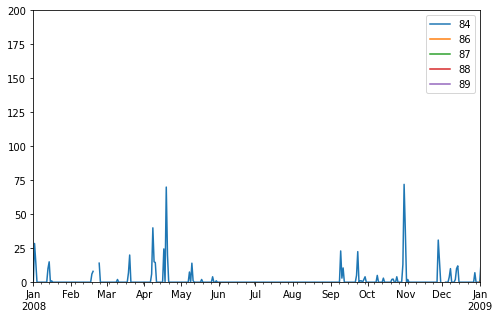

In [46]:
Input_Series.plot(figsize=(8, 5), xlim=['2008-01-01', '2009-01-01'], ylim=[0, 200])

<AxesSubplot:>

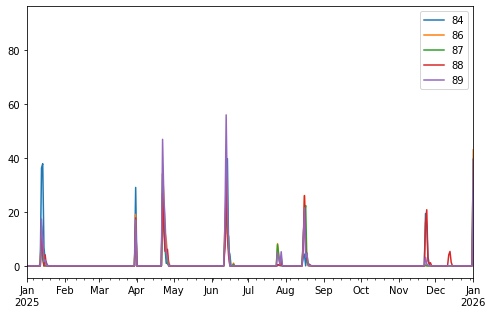

In [47]:
Df_sim_join_day.plot(figsize=(8, 5), xlim=['2025-01-01', '2026-01-01'])

In [48]:
statistics_model_2 = Statistics(hiper_params_cal, time_series = Df_sim_join_day, attributes = Input_Attr)

e:\github\neoprene\NEOPRENE\STNSRP\libs_STNSRP.py:159: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  #print(Correlacion_distancia)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
statistics_model_2.statistics_dataframe

In [ ]:
statistics_model_1.statistics_dataframe

In [ ]:
def STNSRP_simulation(Parametros_meses, Dataframe_xi, year_ini, year_fin, temporal_resolution, I_F, XX, YY,\
                     Pos_tierra, Row_tierra, Colum_tierra, spatially_varying_intensity, Estaciones, storm_radius):
    n=0
    if process=='normal' or process=='cells':
    
        landa=Parametros_meses[Parametros_meses.index=='landa'].values[0];Storm_origin=1/landa##Poisson process
        ipsilon=Parametros_meses[Parametros_meses.index=='ipsilon'].values[0];Number_cells_per_storm=ipsilon##Random poisson mean ¿ipsilon-1?

        if process=='normal':
            eta=Parametros_meses[Parametros_meses.index=='eta'].values[0]; Duracion_cell=1/eta##exponencial random
            if I_F=='W' or I_F=='G':
                alpha=Parametros_meses[Parametros_meses.index=='alpha'].values[0];
        elif process=='cells':    
            eta1=Parametros_meses[Parametros_meses.index=='eta1'].values[0]; Duracion_cell1=1/eta1##exponencial random
            eta2=Parametros_meses[Parametros_meses.index=='eta2'].values[0]; Duracion_cell2=1/eta2##exponencial random
            Dataframe_xi2=Dataframe_xi.copy()
            Dataframe_xi2=Dataframe_xi2*eta1/eta2
            alpha_p1=Parametros_meses[Parametros_meses.index=='alpha_p1'].values[0]
            if I_F=='W' or I_F=='G':
                alpha1=Parametros_meses[Parametros_meses.index=='alpha1'].values[0];
                alpha2=Parametros_meses[Parametros_meses.index=='alpha2'].values[0];

        betha=Parametros_meses[Parametros_meses.index=='beta'].values[0]; Dist_cell_origin=1/betha##exponencial random
        fi_may=Parametros_meses[Parametros_meses.index=='fi_may'].values[0]; Radio=1/fi_may
        if storm_radius==True:
            fi_may_s=Parametros_meses[Parametros_meses.index=='fi_may_s'].values[0]; Radio_s=1/fi_may_s


        time_d=pd.date_range(start=str((year_ini))+'-01-01',  end=str((year_fin))+'-01-01', freq='D')
        time_h=pd.date_range(start=str((year_ini))+'-01-01',  end=str((year_fin))+'-01-01', freq='h')
        time_min=pd.date_range(start=str((year_ini))+'-01-01',  end=str((year_fin))+'-01-01', freq='min')

        Dataframe_simulacion_unido_day_estaciones=pd.DataFrame(index=time_d)
        Dataframe_simulacion_unido_hour_estaciones=pd.DataFrame(index=time_h)
        Dataframe_simulacion_unido_min_estaciones=pd.DataFrame(index=time_min)
        tt=pd.date_range(start=datetime.datetime(year_ini,1, 1),end=datetime.datetime(year_fin,1, 1), freq='min')##Si esto lo pones en
        ##en segundos abajo hay que dividir entre 3600 y no 60
        #tt_ordinal=[datetime2matlabdn(ii) for i, ii in enumerate(tt)]##Solo hay que hacerlo una vez
        #tt_ordinal=list(np.loadtxt('tt_ordinal_10years.txt'))

        ##Two dimensional poisson process (lo más simple sería incrustarlo mi grid en un cuadrado, simular para el cuadrado, 
        #y luego sólo mantener los puntos en la región de destino.
        #print('Maximo radio = ' + str(np.max(np.random.exponential(scale=1/fi_may, size=100000000))) + ' km')
        ##Añado el máximo radio de la tormenta a mi grid. De esta manera sería casi imposible que exitiese una tormenta
        #con un radio más grande y que afectase mi area
        Grados_ventana=np.max(np.random.exponential(scale=1/np.max(fi_may), size=100000000))/111
        P1=[np.min(XX)-Grados_ventana, np.min(YY)-Grados_ventana]; print(P1)
        P2=[np.max(XX)+Grados_ventana, np.min(YY)-Grados_ventana]; print(P2)
        P3=[np.max(XX)+Grados_ventana, np.max(YY)+Grados_ventana]; print(P3)
        P4=[np.min(XX)-Grados_ventana, np.max(YY)+Grados_ventana]; print(P4)
        xp=[P1[0], P2[0], P3[0], P4[0]]; yp=[P1[1], P2[1], P3[1], P4[1]];
        Distnacia_xx_cuadrado_km=haversine(P1[0], P1[1], P2[0], P2[1]); print(Distnacia_xx_cuadrado_km)
        Distnacia_yy_cuadrado_km=haversine(P1[0], P1[1], P4[0], P4[1]); print(Distnacia_yy_cuadrado_km)
        Area_simulacion=Distnacia_xx_cuadrado_km*Distnacia_yy_cuadrado_km; print(Area_simulacion)
        Area_simulacion_degrees=abs((P1[0]-P2[0])*(P1[1]-P3[1]))

        #fi_min=(Number_cells_per_storm*fi_may**2)/(2*np.pi); print(str(fi_min) +' Celdas por km² y por tormenta')#
        fi_min=STNSRP_fi_min(Number_cells_per_storm, fi_may); print(str(fi_min) +' Celdas por km² y por tormenta')#
        mu_c_area=fi_min*Area_simulacion; print(str(mu_c_area) + ' Celdas por tormenta en mi area de simulacion')

        Number_cells_per_storm=mu_c_area
        
        print('Storm ini = ' + str(Storm_origin))

        if storm_radius==True:
            ##Storm radius
            ## Al introducir el radio de la 
            ##tormenta como las celdas que quedan fuera tengo que incluirlas digo que si mi radio de tormenta cubre por
            ##ejemplo la mitad de mi area de simulación entonces tendre el doble de tormentas. El problema es que necesito conocer 
            ##el area media que ocupa intersecta mi tormenta dentro de mi rectangulo. Si la tormenta fuera infinitesimal el area
            ##medí sería el area de mi tormenta y si el radio fuera mas granda que la diagonal mayor del rectangulo mi area media
            ## serie mi area del rectangulo y entonces no habría que dividirlo ni multiplicarlo por nada.
            x_lim=[np.min(xp), np.max(xp)]; y_lim=[np.min(yp), np.max(yp)]
            Area_media_tormenta=list()
            for rs in Radio_s:
                Area_media_tormenta.append(mean_area_intersect_rectangle_circle(x_lim, y_lim, rs/111, 'False'))
            print('Area simulacion degrees ' + str(Area_simulacion_degrees))
            print('Area media tormenta ' + str(Area_media_tormenta))
            Storm_origin_with_storm_radious=(np.array(Area_media_tormenta)/np.array(Area_simulacion_degrees))\
                                            *np.array(Storm_origin)
            Storm_origin=Storm_origin_with_storm_radious
            
        ##Comienzo la simulación
        time_star=datetime.datetime(year_ini, 1, 1)
        time_end=datetime.datetime(year_fin, 1, 1)
        time_lapso=time_star
        time_storm_origins=list()
        n=0
        while time_lapso < time_end:
            if n==0:
                s = np.random.exponential(Storm_origin[0], 1) ##Empiezo con el landa de enero
            else: 
                s = np.random.exponential(Storm_origin[time_lapso.month-1], 1) ##continuao con el landa que corresoponda

            if temporal_resolution=='d':
                time_lapso=time_lapso +  datetime.timedelta(days=s[0])##CAMBIAR dependeindo si estas en h o d
            elif temporal_resolution=='h':
                time_lapso=time_lapso +  datetime.timedelta(hours=s[0])##CAMBIAR dependeindo si estas en h o d

            time_storm_origins.append(time_lapso)
            n=n+1
            
        n_storms=len(time_storm_origins)
               
        if storm_radius==True:    
            
            ##Storm radius (Simulo la posición los centros de las tormentas)
            Rand_01_x=[np.random.uniform(0, 1) for i in range(n_storms)]
            x_storms=np.array(Rand_01_x)*(abs(P1[0]-P2[0])) + P1[0]; 
            Rand_01_y=[np.random.uniform(0, 1) for i in range(n_storms)]
            y_storms=np.array(Rand_01_y)*(abs(P1[1]-P4[1])) + P1[1]; 
            Storm_radius=list()
            for i in (time_storm_origins):
                Storm_radius.append(np.random.exponential(scale=Radio_s[i.month-1],size=1)[0])

        #########################################################################################
        print('Numero de tormentas ' +  str(n_storms))
        Number_cell_per_storm=list()
        Radio_cell=list()
        for i, ii in enumerate(time_storm_origins):
            Number_cell_per_storm.append(1 + (np.random.poisson(Number_cells_per_storm[ii.month-1], 1)))
        print('Numero de celdas de lluvia por tormenta ' + str(np.mean(Number_cell_per_storm)))
        ##########################################################################################
        time0 = datetime.datetime(year_ini, 1, 1)
        time_ini_cells=list()
        time_fin_cells=list()
        Intensidad_cells=list()
        Duracion_horas_cells=list()
        radio_cells=list()
        x_cells=list(); y_cells=list()    

        for i in tqdm.tqdm(range(n_storms)):##numero de rain cells
            time.sleep(0.01)
            time1=time_storm_origins[i] #ojo horas!
            Distancia_horas_cell_sim=np.random.exponential(scale=Dist_cell_origin[time1.month-1], size=Number_cell_per_storm[i])
            Rand_01_x=[np.random.uniform(0, 1) for i in range(Number_cell_per_storm[i])]
            Rand_x=np.array(Rand_01_x)*(abs(P1[0]-P2[0])) + P1[0];
            Rand_01_y=[np.random.uniform(0, 1) for i in range(Number_cell_per_storm[i])]
            Rand_y=np.array(Rand_01_y)*(abs(P1[1]-P4[1])) + P1[1]; 

            for j in range(Number_cell_per_storm[i]):

                if process=='normal':
                    Duracion_horas_cell_sim=np.random.exponential(scale=Duracion_cell[time1.month-1], size=1)

                    if spatially_varying_intensity=='Normal':

                        pos_teta=(np.argmin(sqrt((Estaciones_Tenerife.LON-Rand_x[j])**2 + (Estaciones_Tenerife.LAT-Rand_y[j])**2 )))
                        name_estacion=Dataframe_xi.columns[pos_teta]

                        if I_F=='E':
                            Intensidad_cell_sim=np.random.exponential(scale=1/Dataframe_xi[name_estacion][time1.month],\
                                                                      size=1)
                        elif I_F=='W':
                            Intensidad_cell_sim=np.random.weibull(alpha[time1.month-1], size=1)\
                            *1/Dataframe_xi[name_estacion][time1.month]
                        elif I_F=='G':
                            Intensidad_cell_sim=np.random.gamma(alpha[time1.month-1], 1/Dataframe_xi[name_estacion][time1.month],\
                                                                size=1)
                    elif spatially_varying_intensity=='IDW':

                        IDW=IDW_f(Estaciones.LON.values, Estaciones.LAT.values, \
                                  1/Dataframe_xi[Dataframe_xi.index==time1.month].values[0], Rand_x[j], Rand_y[j], 2)

                        if I_F=='E':
                            Intensidad_cell_sim=np.random.exponential(scale=IDW, size=1)
                        elif I_F=='W':
                            Intensidad_cell_sim=np.random.weibull(alpha[time1.month-1], size=1)*IDW
                        elif I_F=='G':
                            Intensidad_cell_sim=np.random.gamma(alpha[time1.month-1], IDW, size=1)


                if temporal_resolution=='d':
                    time1_cell=time1 + datetime.timedelta(days=Distancia_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d
                    time2_cell=time1_cell + datetime.timedelta(days=Duracion_horas_cell_sim[0])##CAMBIAR dependeindo si estas en h o d   
                    
                elif temporal_resolution=='h':
                    time1_cell=time1 + datetime.timedelta(hours=Distancia_horas_cell_sim[j])##CAMBIAR dependeindo si estas en h o d
                    time2_cell=time1_cell + datetime.timedelta(hours=Duracion_horas_cell_sim[0])##CAMBIAR dependeindo si estas en h o d

                radio_cells.append(np.random.exponential(scale=Radio[time1.month-1], size=1))
                time_ini_cells.append(time1_cell)
                time_fin_cells.append(time2_cell)
                x_cells.append(Rand_x[j]); y_cells.append(Rand_y[j]);
                Intensidad_cells.append(Intensidad_cell_sim[0])
                Duracion_horas_cells.append(Duracion_horas_cell_sim[0])

        ################################################################################
        time_ini_cells=np.array(time_ini_cells)
        time_fin_cells=np.array(time_fin_cells)
        Intensidad_cells=np.array(Intensidad_cells)
        x_cells=np.array(x_cells); y_cells=np.array(y_cells)
        radio_cells=np.array(radio_cells)
        Duracion_horas_cells=np.array(Duracion_horas_cells)
        #################################################################################
        ############################################################################
        tt=pd.date_range(start=Dataframe_simulacion_day_aux[0],end=Dataframe_simulacion_day_aux[-1], freq='min')##Si esto lo pones en
        #tt=pd.date_range(start=datetime.datetime(year_ini,1, 1),end=datetime.datetime(year_fin,1, 1), freq='min')##Si esto lo pones en
        ##en segundos abajo hay que dividir entre 3600 y no 60
        tt_ordinal=[datetime2matlabdn(ii) for i, ii in enumerate(tt)]##Solo hay que hacerlo una vez
        ############################################################################
        Anhos=list()
        for i, ii in enumerate(time_fin_cells):
            aux=ii; year_aux=aux.year
            Anhos.append(year_aux)
        ##Quito las cendas que dentro de una tormenta caen fuera del año límite
        Dentro_fechass=np.where(np.array(Anhos)<year_fin)
        time_ini_cellss=time_ini_cells[Dentro_fechass[0]]
        time_fin_cellss=time_fin_cells[Dentro_fechass[0]]
        Intensidad_cellss=Intensidad_cells[Dentro_fechass[0]]
        Duracion_horas_cellss=Duracion_horas_cells[Dentro_fechass[0]]
        Intensidad_cells=Intensidad_cells[Dentro_fechass[0]]
        x_cells=x_cells[Dentro_fechass[0]]; y_cells=y_cells[Dentro_fechass[0]]; 
        radio_cells=radio_cells[Dentro_fechass[0]];

        if temporal_resolution=='d':
            Hiper_matrix=np.ones((len(XX[:,0]), len(XX[0,:]), len(time_d)))*0
        elif temporal_resolution=='h':
            Hiper_matrix=np.ones((len(XX[:,0]), len(XX[0,:]), len(time_h)))*0

        for rr in tqdm.tqdm(range(len(Pos_tierra[0]))):
            time.sleep(0.01)
            ##Veo las celdas de lluvia que tocan el primer grid
            x_aux=XX[Row_tierra[rr], Colum_tierra[rr]]; y_aux=YY[Row_tierra[rr], Colum_tierra[rr]]
            celdas_mojan=list()
            for ccc in range(len(Intensidad_cells)):
                distancia_celda_grid=(haversine(x_aux, y_aux, x_cells[ccc], y_cells[ccc]))
                if radio_cells[ccc]>distancia_celda_grid:
                    celdas_mojan.append(ccc)

            zeros=np.zeros((len(Dataframe_simulacion_unido_min_estaciones.index), 1))
            aux_t=np.zeros((len(Dataframe_simulacion_unido_min_estaciones.index), 1))

            time_ini_cells_aux=time_ini_cells[celdas_mojan]
            time_fin_cells_aux=time_fin_cells[celdas_mojan]
            Intensidad_cells_aux=Intensidad_cells[celdas_mojan]
            Duracion_cells_aux=Duracion_horas_cells[celdas_mojan]
            x_cells_aux=x_cells[celdas_mojan]; y_cells_aux=y_cells[celdas_mojan]
            radio_cells_aux=radio_cells[celdas_mojan]

            if storm_radius==True:
                ##Ahora voy a quitar las celdas que no mojan por que se salen del radio de la tormenta
                time_ini_cells_aux_storm=list();
                time_fin_cells_aux_storm=list();
                Intensidad_cells_aux_storm=list();
                Duracion_cells_aux_storm=list()
                x_cells_aux_storm=list(); y_cells_aux_storm=list();
                radio_cells_aux_storm=list()
                for s, ss in enumerate(time_storm_origins):
                    if s+1<len(time_storm_origins):
                        posi_celdas_tormenta=(time_ini_cells_aux>time_storm_origins[s]) & (time_ini_cells_aux<time_storm_origins[s+1])
                        posi_celdas_tormenta=np.where(posi_celdas_tormenta)[0]
                    else:
                        posi_celdas_tormenta=(time_ini_cells_aux>time_storm_origins[s])
                        posi_celdas_tormenta=np.where(posi_celdas_tormenta)[0]

                    for c in range(len(posi_celdas_tormenta)):
                        ##Veo si el pixel está dentro de la tormenta 
                        distancia_celda_storm=(haversine(x_storms[s], y_storms[s], x_cells_aux[posi_celdas_tormenta[c]],\
                                                         y_cells_aux[posi_celdas_tormenta[c]]))
                        if Storm_radius[s]+radio_cells_aux[posi_celdas_tormenta[c]]>distancia_celda_storm:
                            time_ini_cells_aux_storm.append(time_ini_cells_aux[posi_celdas_tormenta[c]]);
                            time_fin_cells_aux_storm.append(time_fin_cells_aux[posi_celdas_tormenta[c]])
                            Intensidad_cells_aux_storm.append(Intensidad_cells_aux[posi_celdas_tormenta[c]])
                            Duracion_cells_aux_storm.append(Duracion_cells_aux[posi_celdas_tormenta[c]])
                            x_cells_aux_storm.append(x_cells_aux[posi_celdas_tormenta[c]])
                            y_cells_aux_storm.append(y_cells_aux[posi_celdas_tormenta[c]])
                            radio_cells_aux_storm.append(radio_cells_aux[posi_celdas_tormenta[c]][0])

                time_ini_cells_aux=np.array(time_ini_cells_aux_storm)
                time_fin_cells_aux=np.array(time_fin_cells_aux_storm)
                Intensidad_cells_aux=np.array(Intensidad_cells_aux_storm)


            ##Acumulo cada celda de lluvia en minutos para luego agruparlo en horas
            zeros=np.zeros((len(Dataframe_simulacion_unido_min_estaciones.index), 1))
            aux_t=np.zeros((len(Dataframe_simulacion_unido_min_estaciones.index), 1))
            t_ini = np.hstack([time_ini_cells_aux, time_fin_cells_aux])
            i_ini = np.hstack([Intensidad_cells_aux, -Intensidad_cells_aux])
            orden = np.argsort(t_ini)
            t = t_ini[orden]
            i = np.cumsum(i_ini[orden])
            i[i<0] = 0
            rain=i.copy()
            t_ordinal=[datetime2matlabdn(ii) for i, ii in enumerate(t)]
            rainfall = interp1d(t_ordinal, rain, kind="zero", bounds_error=False, fill_value=0.)
            rrain = rainfall(tt_ordinal)
            Date=pd.DataFrame(index=tt)
            if temporal_resolution=='d':
                Date['Rain']=rrain/(60*24)
                Dataframe_simulacion_unido=Date.resample('D', how='sum')
                Hiper_matrix[Row_tierra[rr], Colum_tierra[rr], :]=Dataframe_simulacion_unido['Rain'].values
            elif temporal_resolution=='h':
                Date['Rain']=rrain/(60)###calculo todo en horas y lo estoy interpolando a minutos por eso lo divido entre 60. Si interpolase
                Dataframe_simulacion_unido=Date.resample('h', how='sum')
                Hiper_matrix[Row_tierra[rr], Colum_tierra[rr], :]=Dataframe_simulacion_unido['Rain'].values
            ##a segundos habria que utilizar poner otro 60. Si las tormentas son muy pequeñas pierdo algo de información haciendolo
            ##en minutos...El problma es que en segundos tarda una eternidad
            #Date['Rain']=rr/3600###calculo todo en horas y lo estoy interpolando a minutos por eso lo divido entre 60. Si interpolase
            ##a segundos habria que utilizar poner otro 60 

            del Date, rainfall, t_ordinal, rrain, i, t, orden, t_ini, i_ini, aux_t, zeros
        
        Hiper_matrix[Hiper_matrix<0.01]==0
        return Hiper_matrix, Dataframe_simulacion_unido